# Linear neural networks - torch API

* `data` module for data handling
* `nn` module for model definition
* `optim` for optimization

## Steps to do:

1. get training data
2. prepare data loading
3. define model
4. define optimization procedure
5. train model (and evaluate)

## Problem description

Generate same data as last week: price of flat in Wurzbrug based on its size (in sqm) and time since last renovation (in yrs) - input: $\mathbf{x} \in \mathbb{R}^2$, output: $y \in \mathbb{R}$

In [1]:
# copy data from last week
import torch
# Fix number of data examples (e.g. to 1000)
n=1000
# generate random input data
x1 = torch.normal(70,20,(n,1))
x2 = torch.normal(5,2,(n,1))
# clamp all entries of a tensor to a limit range
x1 = torch.clamp(x1,min=20,max=150)
#x1 = x1.clamp(min=20,max=150)   this syntax is also correct!
#x1.clamp_(min=20,max=150)    it is replacement assignment (_) directly apply to the object
x2 = torch.clamp(x2,min=0,max=10)
# make sure the iputs are a single tensor with 2 colums
x = torch.cat((x1,x2),dim=1)
print(x1.min(),x1.max())
print(x2.min(),x2.max())
x
# If we need the same numbers for our sample everytime, 
# we need to set the seed to a fix number, otherwise it will creat random numbers

tensor(20.) tensor(130.5907)
tensor(0.) tensor(10.)


tensor([[ 57.6435,   6.6122],
        [ 66.8953,   5.2096],
        [ 87.4713,   6.8865],
        ...,
        [ 59.7625,   1.0118],
        [106.7124,   4.1853],
        [ 80.7186,   4.5944]])

In [5]:
# fix true parameters for the linear regression
w_true = torch.tensor([10., -20.])
w_true.shape
# bias
b_true = 100.
# generate outputs from linear regression model y = x^T w + b + e
y = x.matmul(w_true) + b_true + torch.normal(0.,5.,(n,))

### Data loading

Replace own batch generator by `torch.utils.data` API - `DataLoader, TensorDataset` https://pytorch.org/docs/stable/data.html

In [8]:
# use torch data.DataLoader and data.TensorDataset to prepare batch processing
from torch.utils.data import DataLoader, TensorDataset
ds = TensorDataset(x,y)
dl = DataLoader(ds, batch_size=50, shuffle=True)

### Iterate through data

Check your dataloader works by iterating once through all the data and printing out the batch at every iteration.

In [25]:
# write a for loop to load batches from data and print out the batches
for batch  in ( dl):
  print(batch)

[tensor([[ 70.3939,   3.0346],
        [ 38.9865,   2.9314],
        [ 93.4162,   7.1218],
        [ 73.9406,   4.1347],
        [ 30.9649,   5.5880],
        [111.0333,   3.3827],
        [ 52.2890,   3.6893],
        [ 44.1408,   4.1503],
        [ 61.5144,   8.1728],
        [ 40.7148,   1.7676],
        [ 50.2689,   6.7471],
        [ 59.1033,   3.1528],
        [ 98.8043,   5.5324],
        [ 61.7911,   6.1168],
        [ 49.3390,   6.4257],
        [ 66.7804,   0.6370],
        [ 84.3173,   6.0504],
        [116.6698,   2.9223],
        [ 69.7074,   4.5357],
        [ 80.9968,   6.8895],
        [ 36.0819,   7.0781],
        [ 63.7789,   3.5348],
        [ 63.1409,   7.1655],
        [ 84.1065,   5.6691],
        [ 83.8977,   4.7876],
        [ 79.9501,   5.1626],
        [ 82.7727,   9.1158],
        [ 80.3367,   6.1212],
        [ 51.5196,   5.0885],
        [ 63.8244,   6.3554],
        [103.5856,   5.7077],
        [ 96.9600,   8.4531],
        [ 81.5081,   4.7841],
        [

### Model definition

We still work with linear regression $\hat{y} = \mathbf{x}^T \mathbf{w} + b$ but using `torch.nn` module and the `nn.Linear` layer therein.

In [14]:
# instantiate lin_reg model as linear neural network from torch.nn
import torch.nn as nn
lin_model = nn.Linear(2, 1,bias=True) #two inputs size and year, 1 output price and bias=2
lin_model

Linear(in_features=2, out_features=1, bias=True)

In [15]:
# check the parameters initialized automatically and randomly
lin_model.weight

Parameter containing:
tensor([[ 0.6369, -0.4312]], requires_grad=True)

In [18]:
for name,param in lin_model.named_parameters():
  print(name)
  print(param)

weight
Parameter containing:
tensor([[ 0.6369, -0.4312]], requires_grad=True)
bias
Parameter containing:
tensor([0.4468], requires_grad=True)


In [19]:
for param in lin_model.parameters():
  print(param)

Parameter containing:
tensor([[ 0.6369, -0.4312]], requires_grad=True)
Parameter containing:
tensor([0.4468], requires_grad=True)


In [23]:
lin_model.bias

Parameter containing:
tensor([0.4468], requires_grad=True)

### Loss function definition

We use squared error loss function $\mathcal{L} = \frac{1}{n} \sum_{i = 1}^{n} \frac{1}{2}(\hat{y}^{(i)} - y^{(i)})^2$ predefined in `torch.nn`

In [20]:
# instantiate loss from torch.nn
loss_func = nn.MSELoss()
loss_func

MSELoss()

### Optimization algorithm

We use minibatch stochastic gradient descent predefined in the `nn.optim` module.

In [24]:
import torch.optim as optim
optimizer = optim.SGD(lin_model.parameters(), lr =0.01)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Model training

After all the pieces are ready, we implemen the main training loop. It needs to do the following:

* initiate randomly the linear model parameters $(\mathbf{w}, b)$
* repeat for each epoch (unitl done)
    * load batch of data
    * do linear model precitions with current parameter values
    * calculate loss
    * get gradients
    * update parameter values

In [38]:
# write the training procedure
#data processing 
ds = TensorDataset(x,y)
dl = DataLoader(ds, batch_size=50, shuffle=True)
#model
lin_model = nn.Linear(2, 1,bias=True) #two inputs size and year, 1 output price and bias=2
#loss
loss_func=nn.MSELoss()
#optimizer
optimizer = optim.SGD(lin_model.parameters(), lr =0.00001)

max_epochs = 4
losses = []
for epoch in range(max_epochs):
  for batch in dl:
    x_batch, y_batch =  batch[0], batch[1]
    preds =  lin_model(x_batch) #Predictions
    loss = loss_func(preds,y_batch)
    loss.backward() # get gradients
    optimizer.zero_grad()
    optimizer.step()
    #print(f'Loss {loss}')
    losses.append(loss.item())
  print(losses)

[559060.625, 561752.5, 565047.625, 542455.5625, 587513.3125, 605626.5625, 557278.8125, 619369.6875, 630004.0, 584005.1875, 544148.25, 518820.40625, 547137.0, 525786.5, 556014.6875, 525821.5625, 581959.5625, 642398.6875, 619326.125, 662991.5]
[559060.625, 561752.5, 565047.625, 542455.5625, 587513.3125, 605626.5625, 557278.8125, 619369.6875, 630004.0, 584005.1875, 544148.25, 518820.40625, 547137.0, 525786.5, 556014.6875, 525821.5625, 581959.5625, 642398.6875, 619326.125, 662991.5, 539997.4375, 593581.0625, 534961.8125, 562950.4375, 667572.8125, 677959.4375, 511351.84375, 481216.21875, 625908.125, 479184.59375, 655332.125, 562557.6875, 622896.375, 559621.9375, 620217.25, 589582.9375, 552517.5, 614942.75, 597797.8125, 487727.625]
[559060.625, 561752.5, 565047.625, 542455.5625, 587513.3125, 605626.5625, 557278.8125, 619369.6875, 630004.0, 584005.1875, 544148.25, 518820.40625, 547137.0, 525786.5, 556014.6875, 525821.5625, 581959.5625, 642398.6875, 619326.125, 662991.5, 539997.4375, 593581.06

Text(0.5, 0, 'Iterations')

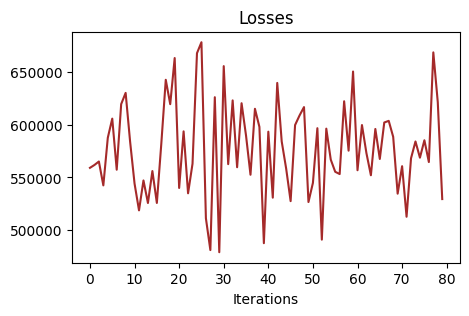

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,3))
plt.plot(losses, color='brown')
plt.title('Losses')
plt.xlabel('Iterations')